Import necessary libraries

In [64]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [65]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [66]:
sns.set_theme(style="darkgrid", rc={"axes.facecolor": "#fcf0dc"})

In [67]:
df = pd.read_csv('input/data.csv', encoding="utf-8-sig")

### Gain a thorough understanding of the dataset

In [68]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010/12/1 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010/12/1 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010/12/1 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010/12/1 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010/12/1 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010/12/1 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010/12/1 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010/12/1 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010/12/1 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010/12/1 8:34,1.69,13047.0,United Kingdom


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [71]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,2011/10/31 14:41,1114
Country,541909,38,United Kingdom,495478


### Data Cleaning & Transformation

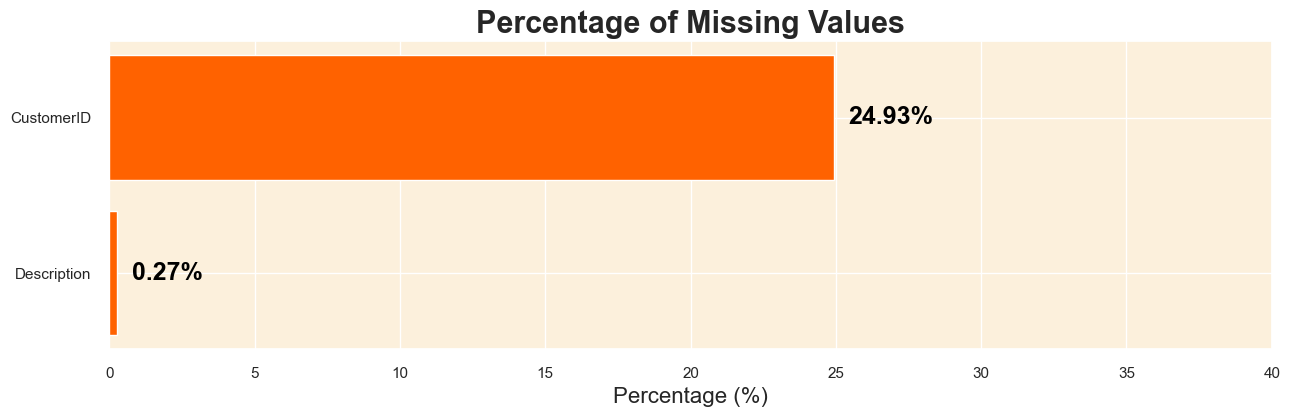

In [ ]:
# calculate the percentage of missing data for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percentage.sort_values(ascending=True, inplace=True)
 
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

ax.set_xlim([0, 40])

plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentage (%)', fontsize=16)
plt.show()

In [ ]:
# get an insight on the missing values in customerID or description columns
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010/12/1 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010/12/1 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010/12/1 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010/12/1 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010/12/1 14:32,1.66,NaN,United Kingdom


In [74]:
df = df.dropna(subset=['CustomerID', 'Description'])

In [75]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
# visually inspect the duplicated rows to see if they are truly duplicated
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010/12/1 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010/12/1 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010/12/1 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010/12/1 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010/12/1 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010/12/1 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010/12/1 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010/12/1 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010/12/1 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010/12/1 11:49,1.65,17920.0,United Kingdom


In [77]:
print(f"The dataset contains {df.duplicated().sum()} duplicated rows.")

df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicated rows.


In [78]:
df.shape[0]

401604

In [79]:
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


#### We need to understand the cancellation patterns of customers to enhance the clustering of customers by using the trends observed in cancellation data, and to prevent the recommendation system from suggesting products that have a high likelihood of being cancelled.

In [80]:
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")


The percentage of cancelled transactions in the dataset is: 2.21%


In [81]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

print(f"The dataset contains {unique_stock_codes} unique stock codes.")


The dataset contains 3684 unique stock codes.


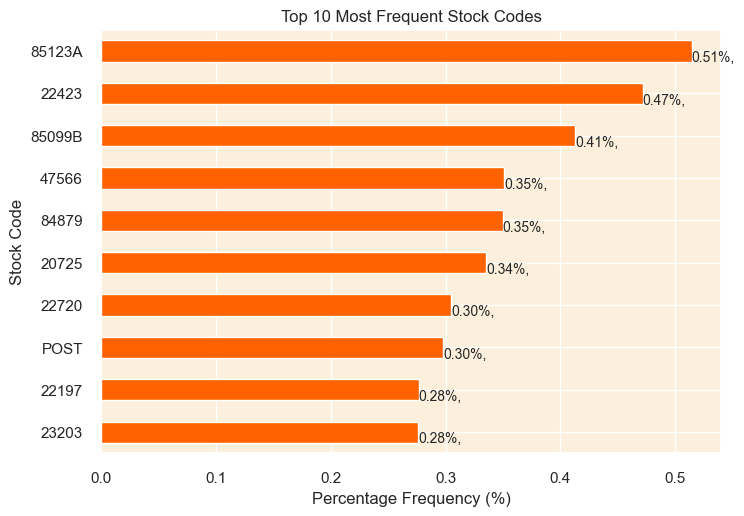

In [82]:
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

plt.Figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%,', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Code')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Finding the number of numeric characters in the stock codes
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_stock_codes = pd.Series(unique_stock_codes).apply(
    lambda x: sum(c.isdigit() for c in str(x))
).value_counts()

print("Value counts of numeric characters in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_stock_codes)

Value counts of numeric characters in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


In [84]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes
                          if sum(c.isdigit() for c in str(code)) in (0, 1)]

print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [85]:
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes)
                        .sum() / df.shape[0]) * 100

print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")


The percentage of records with anomalous stock codes in the dataset is: 0.48%


In [86]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [87]:
df.shape[0]

399689

Cleaning description column

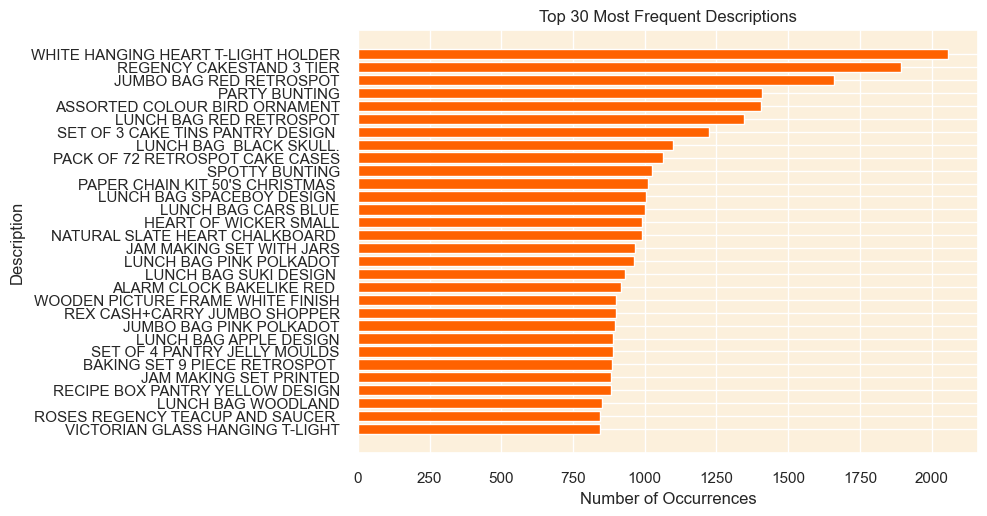

In [88]:
description_counts = df['Description'].value_counts()

top_30_descriptions = description_counts[:30]

plt.Figure(figsize=(12, 8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

plt.show()

In [89]:
lowercase_desciptions = df['Description'].unique()
lowercase_desciptions = [desc for desc in lowercase_desciptions
                         if any(c.islower() for c in desc)]

print("The unique descriptions containing lowercase characters:")
print("-"*60)
for desc in lowercase_desciptions:
    print(desc)

The unique descriptions containing lowercase characters:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [90]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

service_related_descriptions = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

print(f"The percentage of service-related descriptions in the dataset is: {service_related_descriptions:.2f}%")

df['Description'] = df['Description'].str.upper()

df.shape[0]

The percentage of service-related descriptions in the dataset is: 0.02%


399689

In [91]:
df['UnitPrice'].describe()

count    399689.000000
mean          2.907457
std           4.451881
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [92]:
df[df['UnitPrice'] == 0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [93]:
df = df[df['UnitPrice'] > 0]

**RFM Method**

Recency (R)

In [94]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['InvoiceDay'] = df['InvoiceDate'].dt.date

customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

most_recent_date = df['InvoiceDay'].max()

customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])

most_recent_date = pd.to_datetime(most_recent_date)

customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [95]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


Frequency

In [96]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


Monetary

In [97]:
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')

average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


In [98]:
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()
                                                                                 .apply(lambda y: y.days)))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

favourite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favourite_shopping_day = favourite_shopping_day.loc[favourite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

favourite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favourite_shopping_hour = favourite_shopping_hour.loc[favourite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favourite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favourite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,0.000000,2,16


In [99]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.890991
Germany           0.022720
France            0.020398
EIRE              0.018436
Spain             0.006160
Name: proportion, dtype: float64

In [100]:
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,0.000000,2,16,0


In [101]:
customer_data['Is_UK'].value_counts()

Is_UK
1    3869
0     416
Name: count, dtype: int64

In [102]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

cancelled_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

customer_data = pd.merge(customer_data, cancelled_frequency, on='CustomerID', how='left')

customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,0.000000,2,16,0,0.0,0.0


In [103]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()

seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else: # If there is only one data point, return 0
        return 0

spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()

spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [104]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

customer_data = customer_data.convert_dtypes() # this line is to optimize memory usage by upgrading dytpes of each line to the most efficient one


In [105]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,214,1,240,459.4,459.4,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,22,3,1573,2487.43,829.143333,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [106]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4285 entries, 0 to 4284
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4285 non-null   string 
 1   Days_Since_Last_Purchase        4285 non-null   Int64  
 2   Total_Transactions              4285 non-null   Int64  
 3   Total_Products_Purchased        4285 non-null   Int64  
 4   Total_Spend                     4285 non-null   Float64
 5   Average_Transaction_Value       4285 non-null   Float64
 6   Average_Days_Between_Purchases  4285 non-null   Float64
 7   Day_Of_Week                     4285 non-null   Int32  
 8   Hour                            4285 non-null   Int32  
 9   Is_UK                           4285 non-null   Int64  
 10  Cancellation_Frequency          4285 non-null   Int64  
 11  Cancellation_Rate               4285 non-null   Float64
 12  Monthly_Spending_Mean           42

#### Using Isolation Forest to deal with outliers

In [107]:
model = IsolationForest(contamination=0.05, random_state=0)

customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,-1,1
4,12350.0,310,1,196,294.4,294.4,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


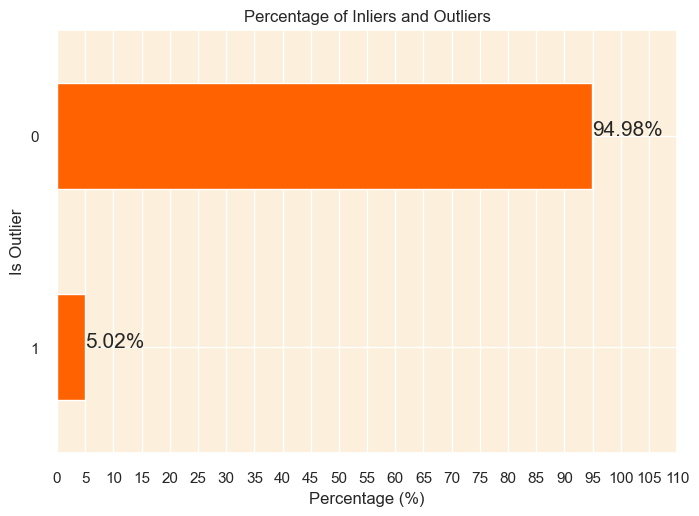

In [108]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.Figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [109]:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

customer_data_cleaned.reset_index(drop=True, inplace=True)

In [110]:
customer_data_cleaned.shape[0]

4070

#### Check the multicollinearity between the features, and remove the highly correlated features using methods like PCA

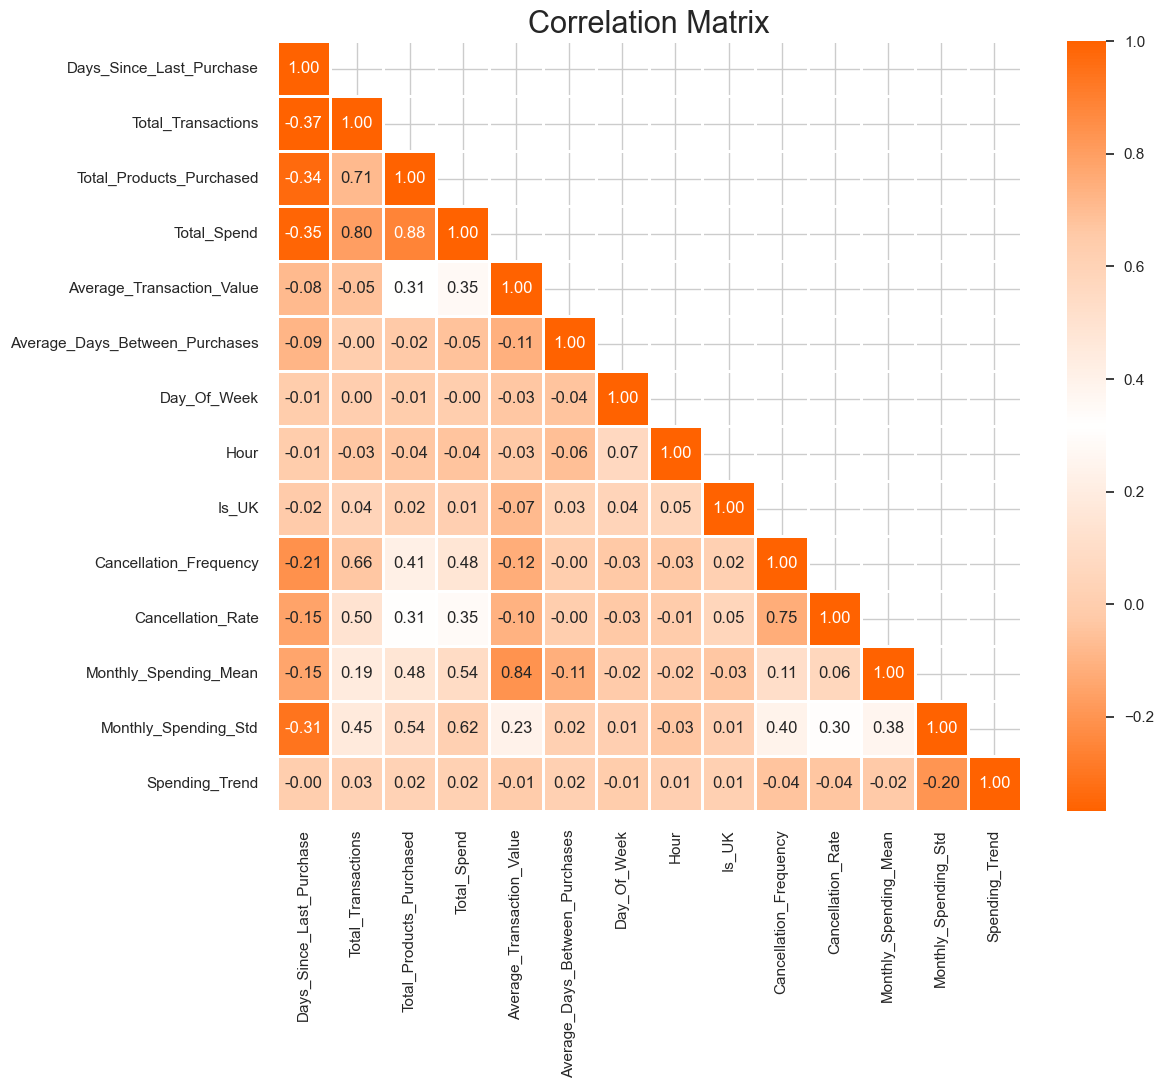

In [111]:
sns.set_style("whitegrid")

corr = customer_data_cleaned.drop(columns='CustomerID').corr()

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, fmt=".2f", linewidths=2)
plt.title('Correlation Matrix', fontsize=22)
plt.show()

#### Feature Scalling

In [112]:
scaler = StandardScaler()

columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

customer_data_scaled = customer_data_cleaned.copy()

customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.351986,-0.472272,-0.757927,-0.819187,-1.336523,-0.308689,1,-1.094097,1,0.354701,0.337542,-1.281296,-0.721745,0.095515
1,12347.0,-0.900255,0.637129,1.993953,2.353498,1.591386,-0.124131,1,0.641279,0,-0.529336,-0.418060,0.966009,1.295436,0.122277
2,12348.0,-0.165228,-0.028512,1.852888,0.238796,0.372105,0.687479,3,2.810499,0,-0.529336,-0.418060,0.030155,0.484029,-0.506312
3,12350.0,2.200953,-0.694152,-0.538493,-0.602473,0.063438,-0.308689,2,1.508967,0,-0.529336,-0.418060,-0.206761,-0.721745,0.095515
4,12352.0,-0.557914,0.859009,-0.239570,0.112309,-0.584347,-0.021997,1,0.641279,0,0.354701,-0.229160,-0.126636,0.074909,0.151299


#### Dimensionality Reduction

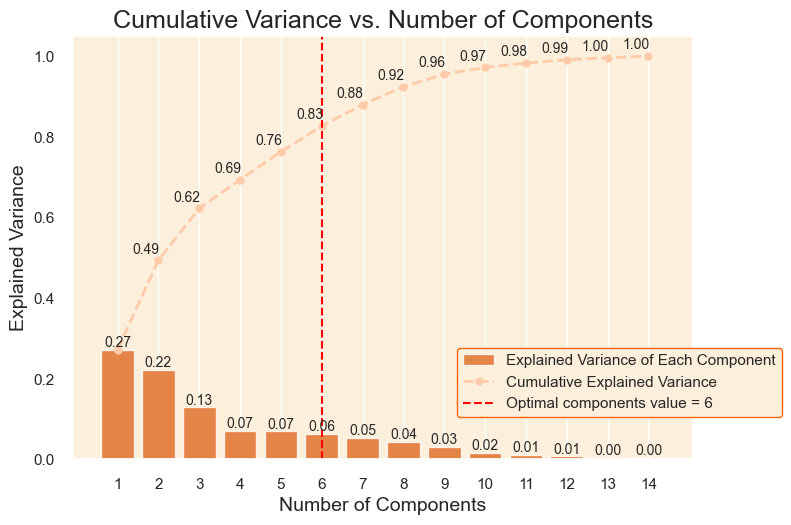

In [113]:
customer_data_scaled.set_index('CustomerID', inplace=True)
pca = PCA().fit(customer_data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

optimal_components = 6

sns.set_theme(style='darkgrid', rc={"axes.facecolor": "#fcf0dc"})

plt.Figure(figsize=(20, 10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y = explained_variance_ratio,
                      color='#ff6200',
                      alpha=0.8)

lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker='o', linestyle='--', color='#ffcaa8', linewidth=2)

optimal_components_line = plt.axvline(optimal_components - 1, color='red',
                                      linestyle='--', label=f'Optimal Components: {optimal_components}')

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_components_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal components value = {optimal_components}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha='center', va='bottom', fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha='center', va='bottom', fontsize=10)

plt.grid(axis='both')
plt.show()

The "elbow point" is around the 6th component, so we retain the first 6 components

In [114]:
pca = PCA(n_components=6)

customer_data_pca = pca.fit_transform(customer_data_scaled)

customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

customer_data_pca.index = customer_data_scaled.index

In [115]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-1.878433,-1.744438,-1.637082,-0.977989,0.275406,-1.792784
12347.0,3.123208,-1.291377,2.068038,0.636908,0.230157,1.026803
12348.0,0.752256,0.639785,0.715865,0.035032,0.248557,2.837381
12350.0,-1.853837,-0.622704,0.471775,-1.180023,1.103221,0.515741
12352.0,0.448040,-1.472702,-0.689280,0.185099,0.360813,0.827588


In [116]:
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color: #ffeacc' if index in top3 else '' for index in column.index]

pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)], index=customer_data_scaled.columns)
pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.222544,-0.023842,0.043066,-0.379189,0.157240,-0.357908
Total_Transactions,0.401931,0.036989,-0.238403,0.085892,0.107452,-0.005239
Total_Products_Purchased,0.419215,0.031665,0.083281,0.128619,0.068647,0.010653
Total_Spend,0.449961,0.035422,0.084105,0.091350,0.071009,-0.005883
Average_Transaction_Value,0.166641,-0.008628,0.603804,-0.046313,0.002204,-0.061693
Average_Days_Between_Purchases,-0.015310,-0.033000,-0.132580,0.598667,-0.459640,0.155447
Day_Of_Week,-0.065623,0.995248,0.002064,0.021268,-0.023557,-0.052580
Hour,-0.027508,0.051112,-0.000077,-0.203828,0.367031,0.868236
Is_UK,0.001700,0.006950,-0.014207,0.004148,0.005057,0.014248
Cancellation_Frequency,0.329506,0.007852,-0.375543,-0.198852,0.064010,-0.115748


### Determine the optimal number of clusters

#### Elbow method

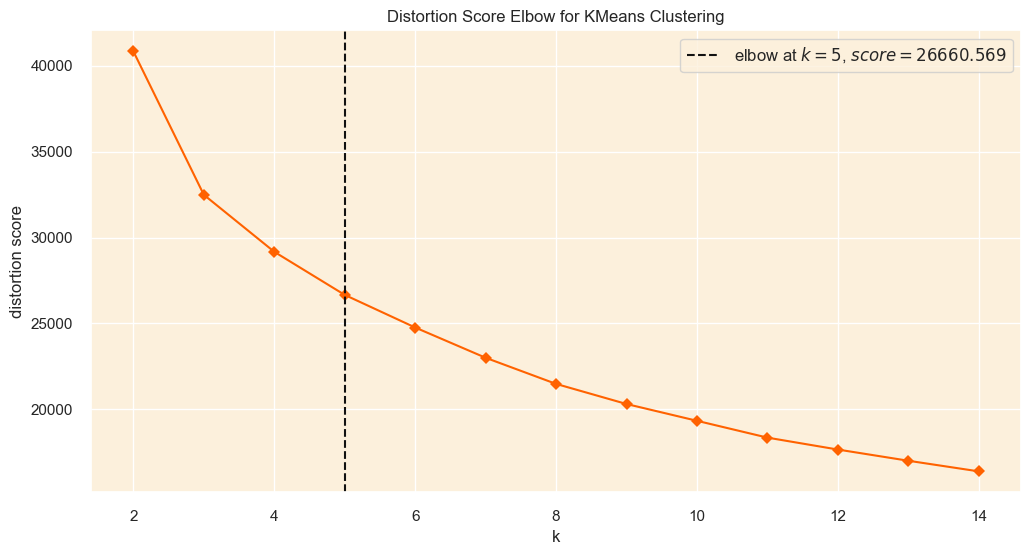

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [117]:
sns.set_theme(style='darkgrid', rc={"axes.facecolor": "#fcf0dc"})

sns.set_palette(['#ff6200'])

km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

fig, ax = plt.subplots(figsize=(12, 6))
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

visualizer.fit(customer_data_pca)
visualizer.show()

#### Silhouette method

In [118]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    plt.figure(figsize=figsize)

    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    first_plot = plt.subplot(grid[0, :])

    sns.set_palette(['darkorange'])
    
    silhouette_scores = []

    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    optimal_k_text  = f'The k value with the highest silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
    
    colors = sns.color_palette('bright')

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)
        ax = plt.subplot(grid[row_idx + 1, col_idx])
        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, ha='right', transform=ax.transAxes, color='red') 
        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()  

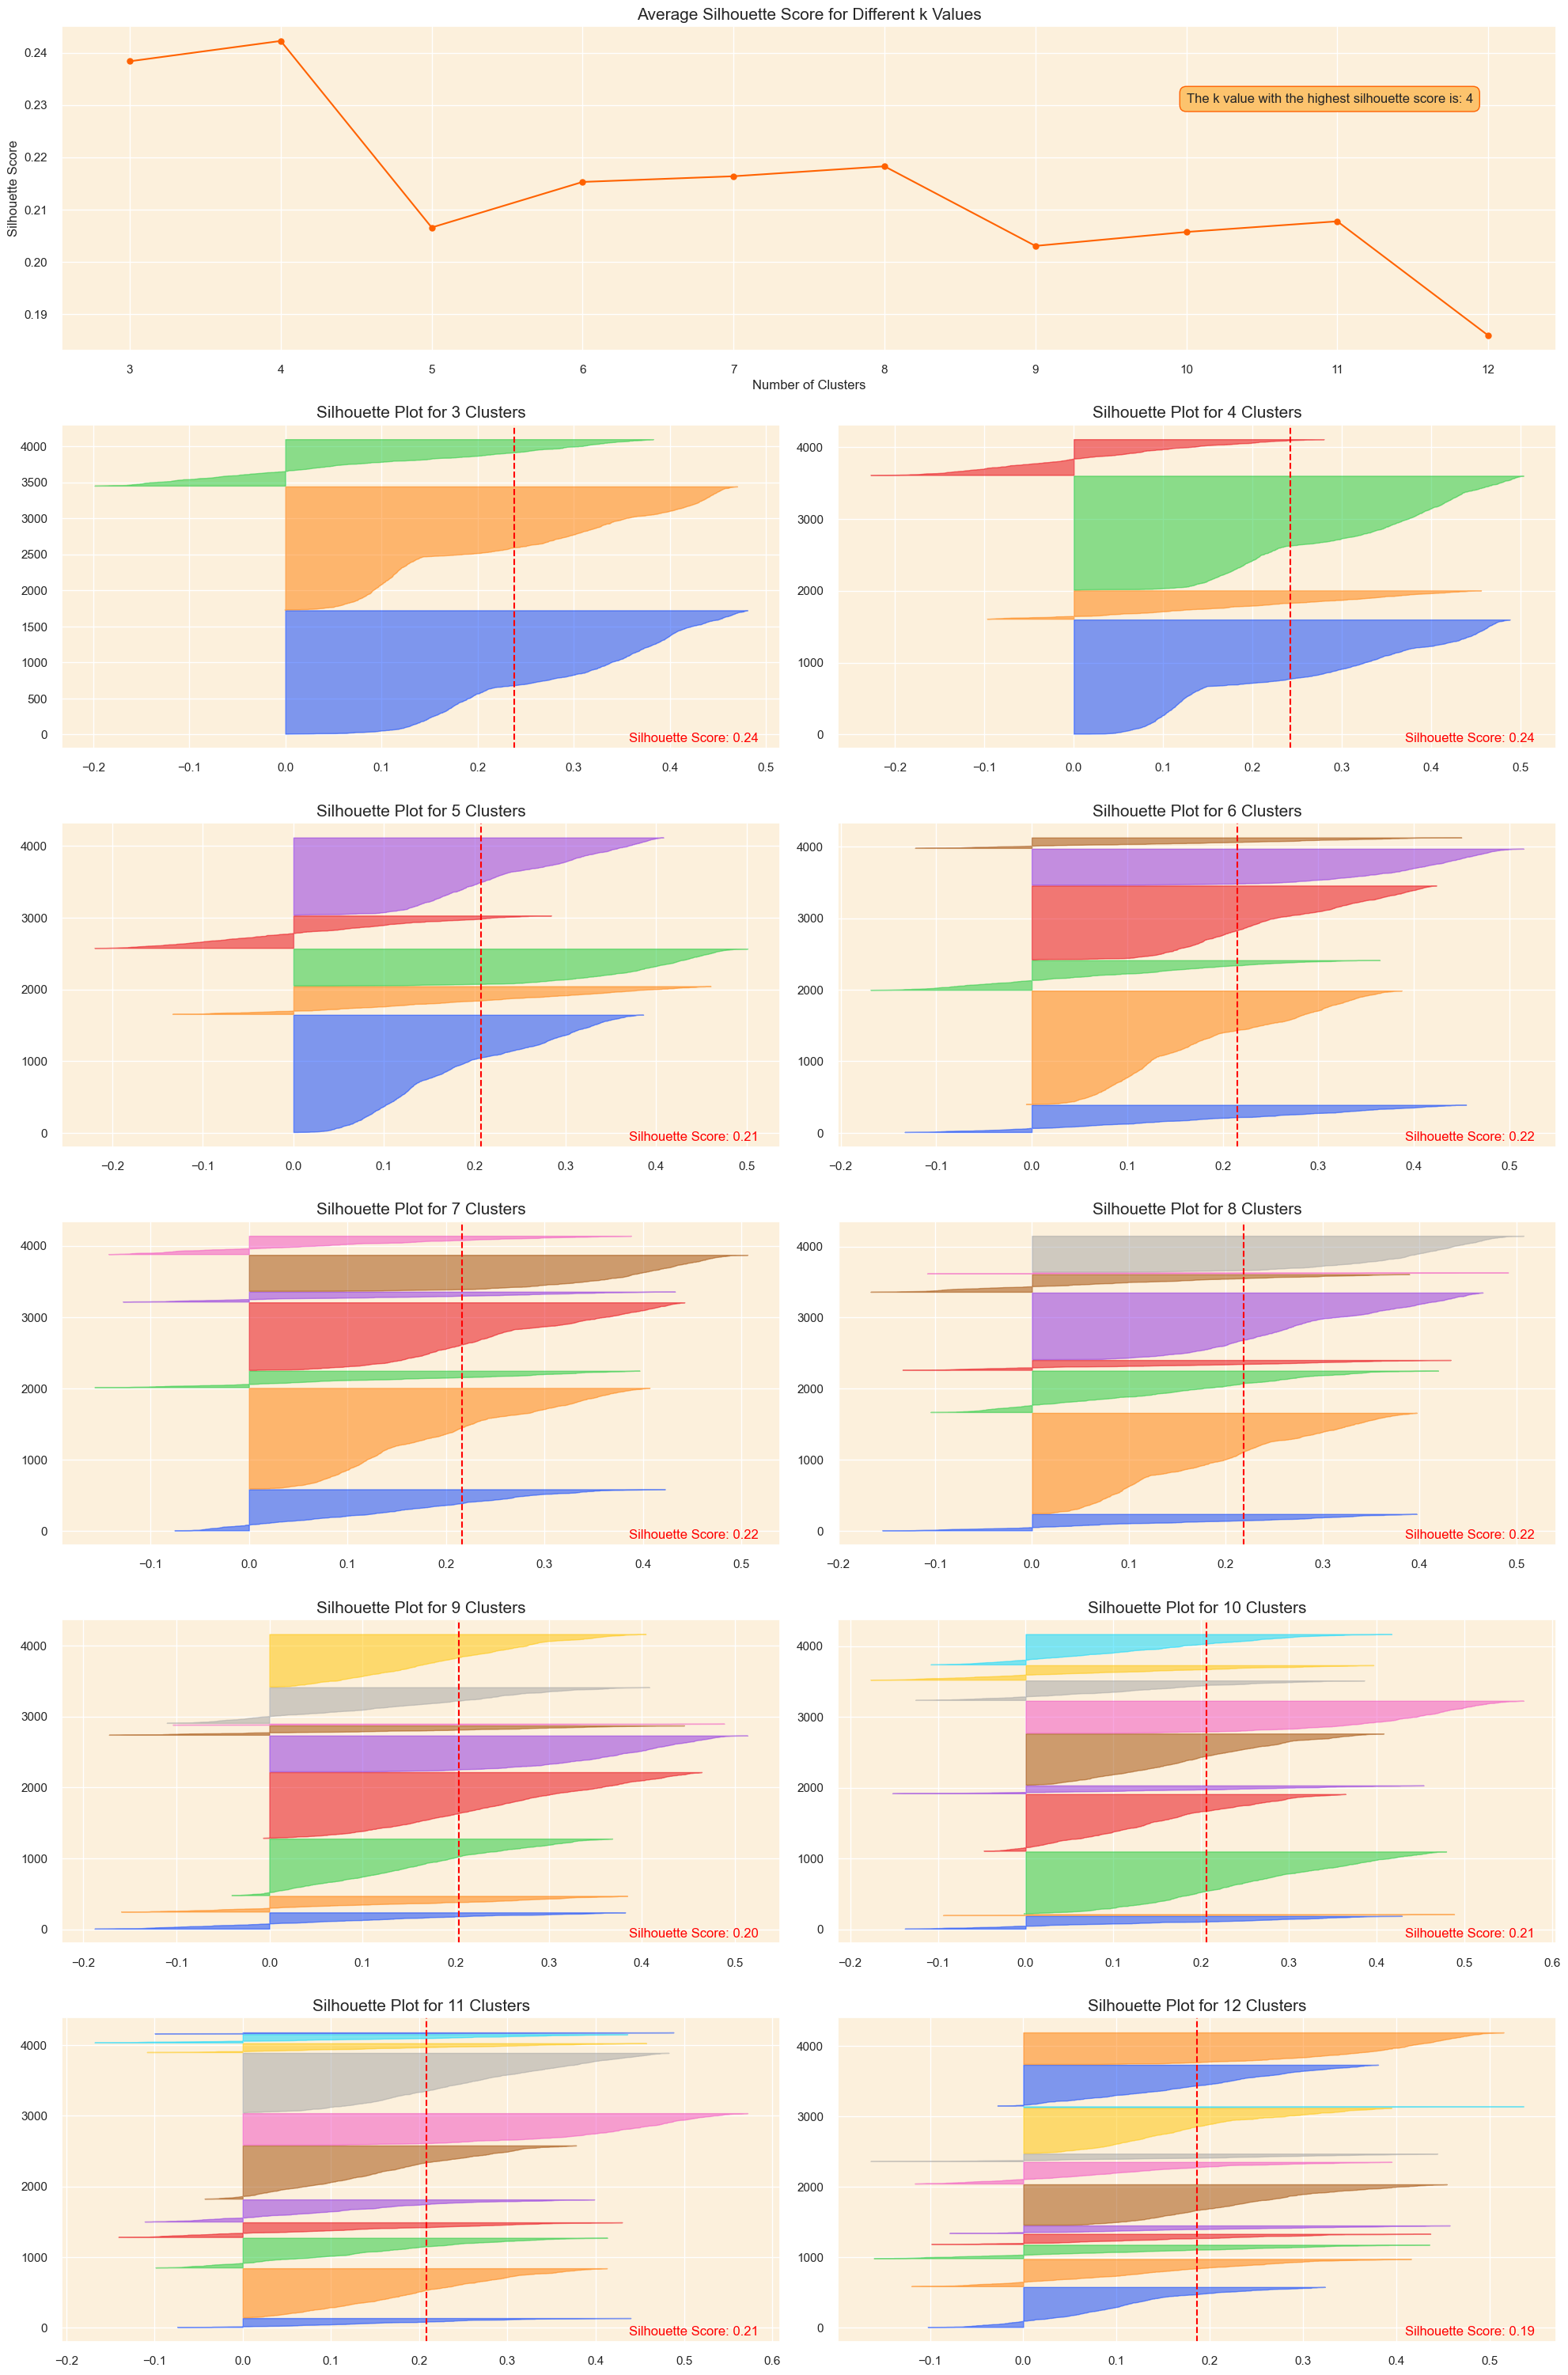

In [119]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

In [120]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

cluster_frequencies = Counter(kmeans.labels_)

label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

customer_data_cleaned['cluster'] = new_labels

customer_data_pca['cluster'] = new_labels

In [121]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,0
2,12348.0,75,4,2332,1437.24,359.31,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,2
3,12350.0,310,1,196,294.4,294.4,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1
4,12352.0,36,8,463,1265.41,158.17625,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351,1


#### 3D Visualization of Top Principal Components

In [122]:
colors = ['#e8000b', '#1ac938', '#023eff']

In [123]:
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

fig = go.Figure()

fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor='#fcf0dc', gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor='#fcf0dc', gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor='#fcf0dc', gridcolor='white', title='PC3')
    ),
    width=900,
    height=800
)

fig.show()

#### Cluster Distribution Visualization

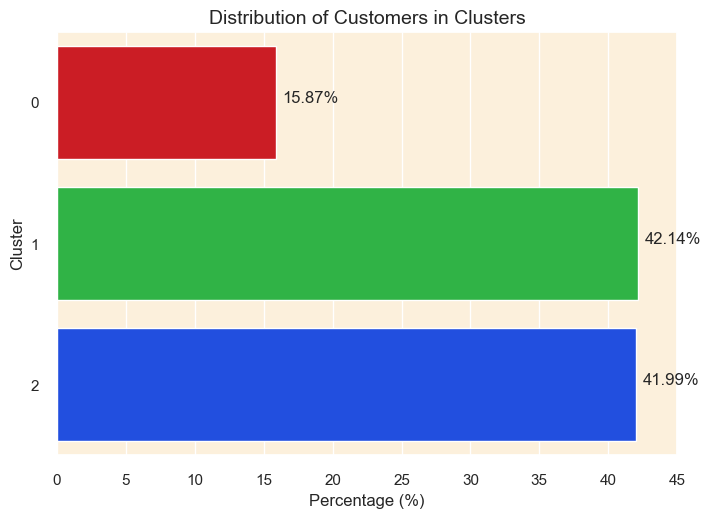

In [124]:
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.Figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers in Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

plt.show()

### Evaluation Metrics

In [125]:
num_observations = len(customer_data_pca)

X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

table_data = [
    ['Number of Observations', num_observations],
    ['Silhouette Score', sil_score],
    ['Calinski-Harabasz Score', calinski_score],
    ['Davies-Bouldin Score', davies_score]
]

print(tabulate(table_data, headers=['Metric', 'Value'], tablefmt='pretty'))


+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4070         |
|    Silhouette Score     | 0.23834637973274234 |
| Calinski-Harabasz Score | 1231.3169803929122  |
|  Davies-Bouldin Score   | 1.3694002919956725  |
+-------------------------+---------------------+


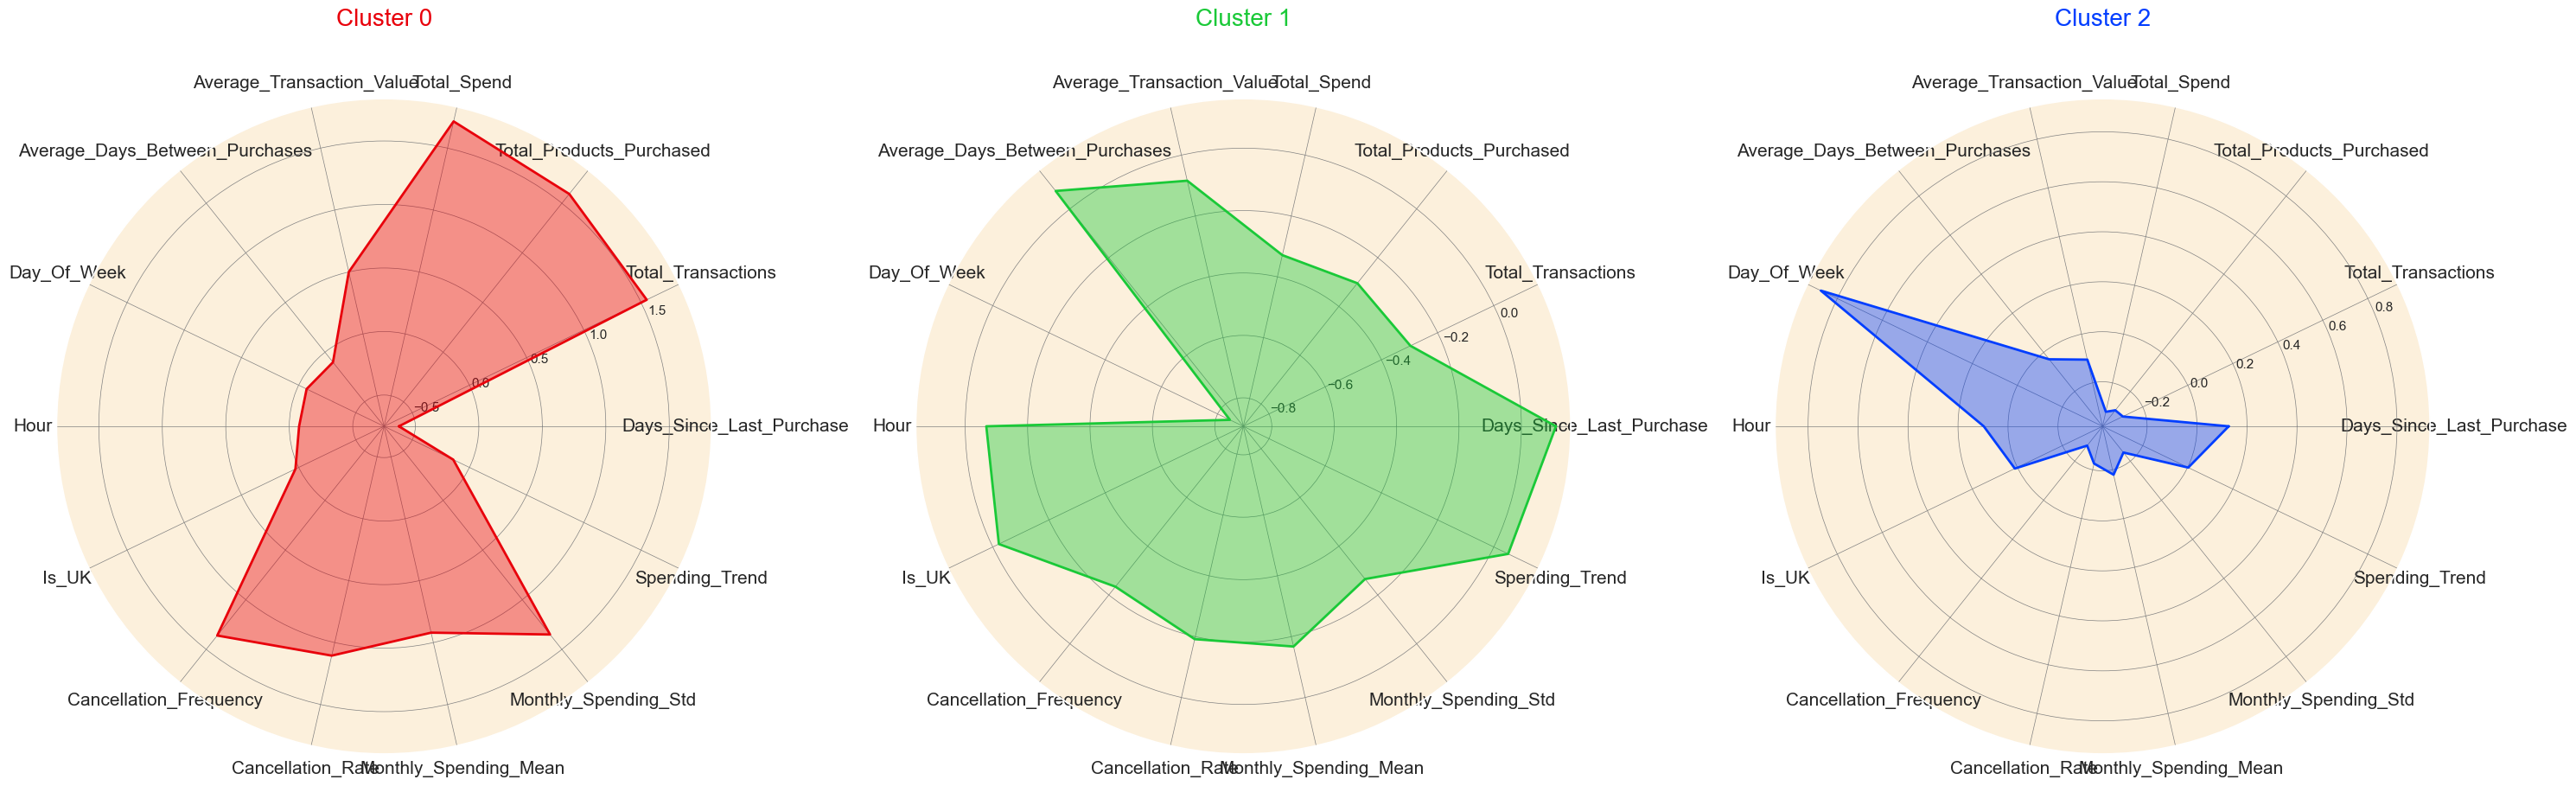

In [129]:
df_customer = customer_data_cleaned.set_index('CustomerID')

scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

cluster_centroids = df_customer_standardized.groupby('cluster').mean()

def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
labels = np.concatenate((labels, [labels[0]]) )
angles += angles[:1]

fig, ax = plt.subplots(figsize=(30, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]
    create_radar_chart(ax[i], angles, data, color, i)

for a in ax:
    a.set_xticks(angles[:-1])
    a.set_xticklabels(labels[:-1], fontsize=15)
    a.grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()

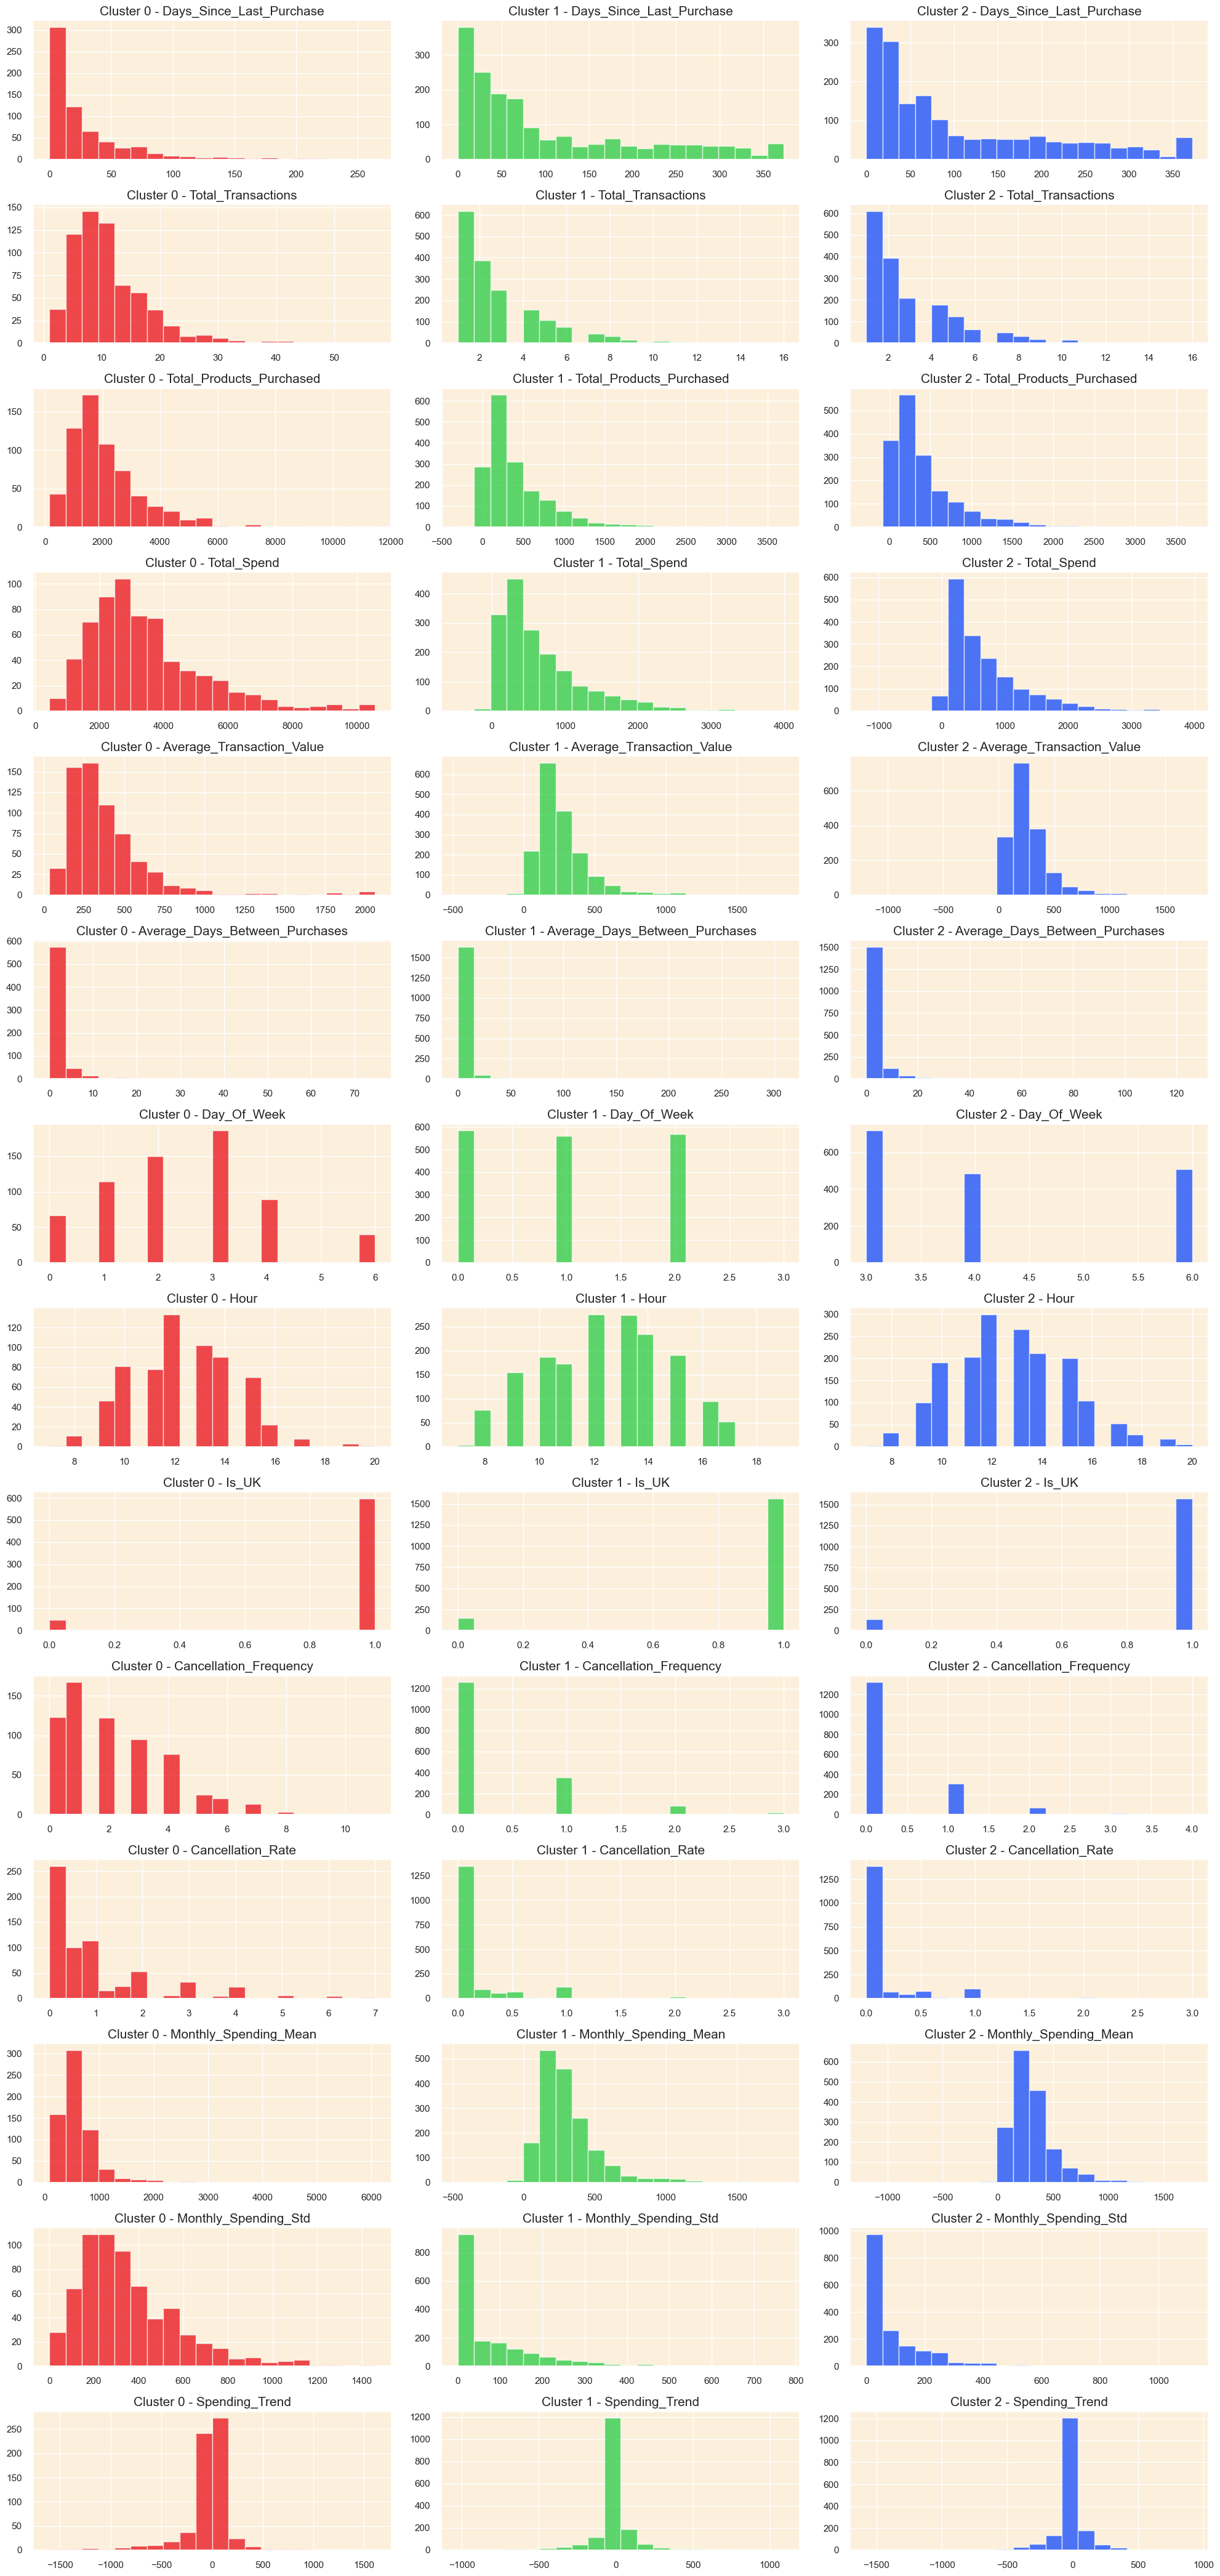

In [130]:
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

for i, features in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][features]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {features}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()

In [137]:
# extract the customerIDs of the outliers and remove their transactions from the dataset
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# ensure consistent data type for customerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# merge the customer data with the filtered transaction data
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# identify the top 10 best-selling products for each cluster
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [138]:
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
16027.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
14834.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER,15036,ASSORTED COLOURS SILK FAN
17636.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER,15036,ASSORTED COLOURS SILK FAN
13933.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
12510.0,84879,ASSORTED COLOUR BIRD ORNAMENT,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85123A,WHITE HANGING HEART T-LIGHT HOLDER
14256.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
17552.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,15036,ASSORTED COLOURS SILK FAN
13993.0,22616,PACK OF 12 LONDON TISSUES,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT
14805.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
